# Оглавление

# Часть 0 : Играем в песочнице

Установим все нужные библиотеки

In [26]:
import pandas as pd
import numpy as np
import tensorflow as tf
import random as rnd
import itertools
from tensorflow import keras
from tensorflow.keras import Model, Input, Sequential, models, layers, optimizers, regularizers, callbacks
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
import scipy as scp
import matplotlib.pyplot as plt
import zipfile
import json
%matplotlib inline

eps = 1e-10

In [27]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


Пока мы ещё маленькие и совсем ничего не понимаем в нейросетях. Сделаем простую игру (что-то в духе камень-ножницы-бумага), чтобы проверить, работает ли модель в принципе и научится ей пользоваться для более сложной задачи, которая ждёт нас впереди.

In [ ]:
def game_1():
    ### ЭТАП 1: МОДЕЛЬ ###
    model = models.Sequential([
        layers.InputLayer(shape=(2,)),  # Вход: 2 героя
        layers.Dense(16, activation='relu'),  # Скрытый слой
        layers.Dense(1, activation='sigmoid')  # Выход: Победитель (0 или 1)
    ])

    ### ЭТАП 2: ОБУЧЕНИЕ ###
    '''
    Генерируем матчи:
    a и b - от 1 до 3.
    Если они совпадают, то мы их не добавляем (мы пока не рассматриваем ничьи)

    '''
    X = np.array([
        [a, b] for _ in range(1500)
        for a, b in [(rnd.randint(1, 3), rnd.randint(1, 3))]
        if a != b
    ])
    Y = np.array([0 if a < b else 1 for a, b in X]) # Номер победившего в паре игрока

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model.fit(X, Y, epochs=50, batch_size=10, verbose=0)

    ### ЭТАП 3: ТЕСТИРОВАНИЕ ###

    # Теперь создадим тестовые игры, чтобы проверить, что нейросеть обучилась
    X_test = np.array([
        [a, b] for _ in range(10)
        for a, b in [(rnd.randint(1, 3), rnd.randint(1, 3))]
        if a != b
    ])

    Y_test = np.array([0 if a < b else 1 for a, b in X_test]) # Правильные ответы
    y_pred = (model.predict(X_test) > 0.5).astype(int)  # Предсказания нашей модели
    errors = 0

    # Сравниваем
    for i in range(len(y_pred)):
        p1 = ['A', 'B', 'C'][X_test[i][0] - 1]
        p2 = ['A', 'B', 'C'][X_test[i][1] - 1]
        if y_pred[i] != Y_test[i]:
            print(f"Ошибка! {i+1}) {p1} против {p2}, победил не {p2 if y_pred[i] else p1}")
            errors += 1
        else:
            print(f"{i+1}) {p1} против {p2} => Победитель: {p2 if y_pred[i] else p1}")
    print("Процент ошибок:", round((errors / len(Y_test)) * 100, 2), "%")

In [ ]:
game_1()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1) C против A => Победитель: A
2) B против C => Победитель: B
3) A против B => Победитель: A
4) A против C => Победитель: A
5) A против B => Победитель: A
6) B против A => Победитель: A
7) B против C => Победитель: B
8) B против C => Победитель: B
9) B против C => Победитель: B
Процент ошибок: 0.0 %


P.s. В дальнейшем мы не будем так подробно расписывать комментарии

 Всё работает, отлично - модель научилась угадывать победителя. Теперь напишем, чтобы она сама участвовала в игре и выбирала себе героя.

In [ ]:
def game_2():
    np.random.seed(42)
    tf.random.set_seed(42)

    ### ЭТАП 1: МОДЕЛЬ ###
    def reward(a, b):
        return ([a, b] in [[0, 1], [0, 2], [1, 2]]) # 0 всегда выигрывает

    model = keras.Sequential([
        keras.layers.Input(shape=(1,)), # Вход : заглушка
        keras.layers.Dense(3, activation='softmax')  # Выход: 3 героя, p их выбора
    ])
    optimizer = keras.optimizers.Adam(learning_rate=0.01)

    ### ЭТАП 2: ОБУЧЕНИЕ ###
    num_episodes = 300   # Эпохи обучения
    games_per_episode = 50    # Матчей за одну эпоху

    for episode in range(num_episodes):
        with tf.GradientTape() as tape:
            # Вероятности для хода
            state_input = tf.ones((games_per_episode, 1), dtype=tf.float32)
            probs = model(state_input, training=True)
            log_probs = tf.math.log(probs + eps)

            # Генерируем ходы модели
            sampled_actions = tf.random.categorical(log_probs, num_samples=1)
            sampled_actions = tf.squeeze(sampled_actions, axis=1)

            # Считаем награду
            rewards = []
            for i in range(games_per_episode):
                model_hero = sampled_actions[i].numpy()
                possible_opp_moves = [x for x in [0,1,2] if x != model_hero]
                opp_hero = np.random.choice(possible_opp_moves)
                rewards.append(reward(model_hero, opp_hero))

            rewards = tf.constant(rewards, dtype=tf.float32)
            chosen_action_log_p = tf.reduce_sum(
                tf.one_hot(sampled_actions, depth=3) * log_probs,
                axis=1
            )
            loss = -tf.reduce_mean(rewards * chosen_action_log_p)

        # Корректируем модель, обновляем веса
        grads = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))

        # Выводим статистику
        if (episode + 1) % 20 == 0:
            mean_reward = tf.reduce_mean(rewards)
            print(f"Episode {episode + 1}/{num_episodes} | Mean reward: {round(mean_reward.numpy(), 2)} | Loss: {round(loss.numpy(), 3)}")

    ### ЭТАП 3: ТЕСТИРОВАНИЕ ###
    print('-' * 52 + '\nТестирование\n' + '-' * 52)
    N_test = 1000
    test_input = tf.ones((N_test, 1), dtype=tf.float32)
    test_probs = model(test_input, training=False)
    test_log_probs = tf.math.log(test_probs + 1e-10)
    test_actions = tf.random.categorical(test_log_probs, num_samples=1)
    test_actions = tf.squeeze(test_actions, axis=1).numpy()

    wins = 0
    L = ['A', 'B', 'C']
    for i in range(N_test):
        model_hero = test_actions[i]
        opp_hero = np.random.choice([x for x in [0, 1, 2] if x != model_hero])
        if reward(model_hero, opp_hero):
            wins += 1
            if i % 50 == 0:
                print(f"Модель с героем {L[model_hero]} обыграла героя соперника {L[opp_hero]}")
        else:
            if i % 50 == 0:
                print(f"x - Модель с героем {L[model_hero]} проиграла герою соперника {L[opp_hero]}")

    win_percent = 100.0 * wins / N_test
    print(f"\nРезультат: модель выиграла в {round(win_percent, 2)}% случаев.")

In [ ]:
game_2()

Episode 20/300 | Mean reward: 0.8199999928474426 | Loss: 0.527999997138977
Episode 40/300 | Mean reward: 0.8199999928474426 | Loss: 0.18400000035762787
Episode 60/300 | Mean reward: 0.8600000143051147 | Loss: 0.11100000143051147
Episode 80/300 | Mean reward: 0.9399999976158142 | Loss: 0.07999999821186066
Episode 100/300 | Mean reward: 0.9800000190734863 | Loss: 0.13300000131130219
Episode 120/300 | Mean reward: 0.9200000166893005 | Loss: 0.04399999976158142
Episode 140/300 | Mean reward: 0.9800000190734863 | Loss: 0.03700000047683716
Episode 160/300 | Mean reward: 0.9599999785423279 | Loss: 0.03099999949336052
Episode 180/300 | Mean reward: 0.9800000190734863 | Loss: 0.11500000208616257
Episode 200/300 | Mean reward: 0.9800000190734863 | Loss: 0.11400000005960464
Episode 220/300 | Mean reward: 1.0 | Loss: 0.11400000005960464
Episode 240/300 | Mean reward: 1.0 | Loss: 0.017999999225139618
Episode 260/300 | Mean reward: 1.0 | Loss: 0.01600000075995922
Episode 280/300 | Mean reward: 1.0 |

УРААААА ГОООООЛ, он что-то выиграл.
Это здорово, что он придумал невероятную тактику всегда выбирать героя А, но что, если правила С будет бить А, а не наоборот. Да и вообще, пора матрицу игр писать, ничью добавить...
А ещё устроим дополнительную проверку модели на адекватность - нужно будет выбирать свой ход исходя из хода соперника ("если у соперника ножницы, то очевидно нужен камень", и т.д.)

p.s. можно заметить, что это уже немного похоже на задачу, которую нам предстоит решить

ОБУЧЕНИЕ

In [ ]:
def game_3():
    ### ЭТАП 1 : МОДЕЛЬ ###

    '''
     Матрица выигрышей:
    0.5 – ничья, 1 – победа, 0 – поражение
    '''
    matrix = [[0.5, 1, 0], [0, 0.5, 1], [1, 0, 0.5]]
    def reward(a, b):
        return matrix[a][b]

    model = keras.Sequential([
        keras.layers.Input(shape=(1,)), # Вход : 1 герой соперника
        keras.layers.Embedding(input_dim=3, output_dim=4),
        keras.layers.Flatten(),
        keras.layers.Dense(3, activation='softmax')  # Выход: 3 героя, p их выбора
    ])
    optimizer = keras.optimizers.Adam(learning_rate=0.01)

    ### ЭТАП 2 : ОБУЧЕНИЕ ###
    num_episodes = 300   # Эпохи обучения
    games_per_episode = 50    # Матчей за одну эпоху

    for episode in range(num_episodes):
        with tf.GradientTape() as tape:
            # Ходы соперника
            opp_hero = np.random.randint(0, 3, size=games_per_episode)

            # Ходы модели
            state_input = tf.constant(opp_hero, dtype=tf.float32)
            state_input = tf.reshape(state_input, (games_per_episode, 1))
            probs = model(state_input, training=True)
            log_probs = tf.math.log(probs + eps)
            sampled_actions = tf.random.categorical(log_probs, num_samples=1)
            sampled_actions = tf.squeeze(sampled_actions, axis=1)

            # Награда
            rewards = []
            for i in range(games_per_episode):
                model_hero = sampled_actions[i].numpy()
                rewards.append(reward(model_hero, opp_hero[i]))

            rewards = tf.constant(rewards, dtype=tf.float32)
            chosen_action_log_p = tf.reduce_sum(
                tf.one_hot(sampled_actions, depth=3) * log_probs,
                axis=1
            )
            loss = -tf.reduce_mean(rewards * chosen_action_log_p)

        # Корректировка
        grads = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))

        # Статистика
        if (episode + 1) % 20 == 0:
            mean_reward = tf.reduce_mean(rewards)
            print(f"Episode {episode+1}/{num_episodes} | Mean reward: {round(mean_reward.numpy(), 2)} | Loss: {round(loss.numpy(), 3)}")

    ### ЭТАП 3 : ТЕСТИРОВАНИЕ ###
    print('-' * 52 + '\nТестирование\n' + '-' * 52)
    N_test = 1000
    opp_hero_test = np.random.randint(0, 3, size=N_test)
    test_input = tf.constant(opp_hero_test, dtype=tf.float32)
    test_input = tf.reshape(test_input, (N_test, 1))

    test_probs = model(test_input, training=False)
    test_log_probs = tf.math.log(test_probs + eps)
    test_actions = tf.random.categorical(test_log_probs, num_samples=1)
    test_actions = tf.squeeze(test_actions, axis=1).numpy()

    wins = 0
    L = ['A', 'B', 'C']
    for i in range(N_test):
        model_hero = test_actions[i]
        opp_hero = opp_hero_test[i]
        r = reward(model_hero, opp_hero)
        wins += r
        if i % 50 == 0 or r < 1:
            if r == 1.0:
                print(f"Модель с героем {L[model_hero]} обыграла героя соперника {L[opp_hero]}")
            elif r:
                print(f"Модель с героем {L[model_hero]} сыграла вничью с героем соперника {L[opp_hero]}")
            else:
                print(f"Ошибка! Модель с героем {L[model_hero]} проиграла герою соперника {L[opp_hero]}")

    win_percent = 100.0 * wins / N_test
    print(f"\nИтоговая проверка: модель выиграла в {round(win_percent, 2)}% матчей.")

In [ ]:
game_3()

Episode 20/300 | Mean reward: 0.5299999713897705 | Loss: 0.421999990940094
Episode 40/300 | Mean reward: 0.8399999737739563 | Loss: 0.33000001311302185
Episode 60/300 | Mean reward: 0.9100000262260437 | Loss: 0.13899999856948853
Episode 80/300 | Mean reward: 1.0 | Loss: 0.019999999552965164
Episode 100/300 | Mean reward: 0.9800000190734863 | Loss: 0.009999999776482582
Episode 120/300 | Mean reward: 0.9900000095367432 | Loss: 0.0560000017285347
Episode 140/300 | Mean reward: 1.0 | Loss: 0.004999999888241291
Episode 160/300 | Mean reward: 1.0 | Loss: 0.004000000189989805
Episode 180/300 | Mean reward: 1.0 | Loss: 0.003000000026077032
Episode 200/300 | Mean reward: 1.0 | Loss: 0.0020000000949949026
Episode 220/300 | Mean reward: 1.0 | Loss: 0.0020000000949949026
Episode 240/300 | Mean reward: 1.0 | Loss: 0.0010000000474974513
Episode 260/300 | Mean reward: 1.0 | Loss: 0.0010000000474974513
Episode 280/300 | Mean reward: 1.0 | Loss: 0.0010000000474974513
Episode 300/300 | Mean reward: 1.0 

Потрясающе, какие мы молодцы.
Теперь представим, что героев у нас не 3, а там, 200. А ещё мы живём в реальном мире, где и везде и повсюду вероятности, так, что есть шанс у героя в неравной схватке с другим изредка выйти победителем.

Все эти вероятности мы учтём в нашей матрице, а после этого проверим нашу модель на работоспособность в самых что ни на есть боевых условиях

In [38]:
def game_4(matrix, hero_number=200):
    ### ЭТАП 1 : МОДЕЛЬ ###
    def reward(a, b):
        return 1 if rnd.random() < matrix[a][b] else 0

    model = keras.Sequential([
        keras.layers.Input(shape=(1,)), # Вход : 1 герой соперника
        keras.layers.Embedding(input_dim=hero_number, output_dim=hero_number+1),
        keras.layers.Flatten(),
        keras.layers.Dense(hero_number, activation='softmax')
    ])
    optimizer = keras.optimizers.Adam(learning_rate=0.01)

    ### ЭТАП 2 : ОБУЧЕНИЕ ###
    num_episodes = 300   # Эпохи обучения
    games_per_episode = 50    # Матчей за одну эпоху

    for episode in range(num_episodes):
        with tf.GradientTape() as tape:
            # Ходы соперника
            opp_hero = np.random.randint(0, hero_number, size=games_per_episode)

            # Ходы модели
            state_input = tf.constant(opp_hero, dtype=tf.float32)
            state_input = tf.reshape(state_input, (games_per_episode, 1))
            probs = model(state_input, training=True)
            log_probs = tf.math.log(probs + eps)
            sampled_actions = tf.random.categorical(log_probs, num_samples=1)
            sampled_actions = tf.squeeze(sampled_actions, axis=1)

            # Награда
            rewards = []
            for i in range(games_per_episode):
                model_hero = sampled_actions[i].numpy()
                rewards.append(reward(model_hero, opp_hero[i]))

            rewards = tf.constant(rewards, dtype=tf.float32)
            chosen_action_log_p = tf.reduce_sum(
                tf.one_hot(sampled_actions, depth=hero_number) * log_probs,
                axis=1
            )
            loss = -tf.reduce_mean(rewards * chosen_action_log_p)

        # Корректировка
        grads = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))

        # Статистика
        if (episode + 1) % 20 == 0:
            mean_reward = tf.reduce_mean(rewards)
            print(f"Episode {episode+1}/{num_episodes} | Mean reward: {round(mean_reward.numpy(), 2)} | Loss: {round(loss.numpy(), 3)}")

    ### ЭТАП 3 : ТЕСТИРОВАНИЕ ###
    print('-' * 52 + '\nТестирование\n' + '-' * 52)
    N_test = 1000
    print(hero_number)
    opp_hero_test = np.random.randint(0, hero_number, size=N_test)
    test_input = tf.constant(opp_hero_test, dtype=tf.float32)
    test_input = tf.reshape(test_input, (N_test, 1))

    test_probs = model(test_input, training=False)
    test_log_probs = tf.math.log(test_probs + eps)
    test_actions = tf.random.categorical(test_log_probs, num_samples=1)
    test_actions = tf.squeeze(test_actions, axis=1).numpy()

    wins = 0
    L = [chr(i + 100) for i in range(hero_number)]
    for i in range(N_test):
        model_hero = test_actions[i]
        opp_hero = opp_hero_test[i]
        r = reward(model_hero, opp_hero)
        wins += r
        if i % 50 == 0:
            if r:
                print(f"Модель с героем {L[model_hero]} обыграла героя соперника {L[opp_hero]}")
            else:
                print(f"Ошибка! Модель с героем {L[model_hero]} проиграла герою соперника {L[opp_hero]}")

    win_percent = 100.0 * wins / N_test
    print(f"\nИтоговая проверка: модель выиграла в {round(win_percent, 2)}% матчей.")

In [39]:
hero_number = 200
matrix = [[rnd.random() * 0.8 for _ in range(hero_number)] for __ in range(hero_number)]
for i in range(hero_number):
    matrix[i][i] = 0.5
    for j in range(i+1, hero_number):
        matrix[i][j] = 1 - matrix[j][i]

game_4(matrix, hero_number)

Episode 20/300 | Mean reward: 0.3799999952316284 | Loss: 2.0199999809265137
Episode 40/300 | Mean reward: 0.4399999976158142 | Loss: 2.319000005722046
Episode 60/300 | Mean reward: 0.5199999809265137 | Loss: 2.7149999141693115
Episode 80/300 | Mean reward: 0.5600000023841858 | Loss: 2.9030001163482666
Episode 100/300 | Mean reward: 0.5 | Loss: 2.5420000553131104
Episode 120/300 | Mean reward: 0.47999998927116394 | Loss: 2.2809998989105225
Episode 140/300 | Mean reward: 0.6399999856948853 | Loss: 2.677000045776367
Episode 160/300 | Mean reward: 0.6399999856948853 | Loss: 2.3459999561309814
Episode 180/300 | Mean reward: 0.6800000071525574 | Loss: 1.906000018119812
Episode 200/300 | Mean reward: 0.5799999833106995 | Loss: 1.2170000076293945
Episode 220/300 | Mean reward: 0.699999988079071 | Loss: 1.2130000591278076
Episode 240/300 | Mean reward: 0.5799999833106995 | Loss: 0.949999988079071
Episode 260/300 | Mean reward: 0.7200000286102295 | Loss: 0.7379999756813049
Episode 280/300 | Mean

Промежуточные итоги : умеем угадывать исход матчей и выбирать оптимального героя под выбор соперника.

Дальше - больше!

# Часть 1 : Парсим датасет

In [28]:
Heroes = []
Heroes_id = {}

with zipfile.ZipFile('/content/drive/MyDrive/data/heroes.zip', 'r') as archive:
    with archive.open('heroes.json') as f:
        heroes_data = json.load(f)
hero_num = 146
Heroes = [None] * hero_num

for hero in heroes_data:
    hero_id = hero['hero_id']
    name = hero['name']
    Heroes[hero_id] = name
    Heroes_id[name] = hero_id


print("Heroes:", Heroes)
print("Heroes_id:", Heroes_id)

Heroes: [None, 'anti-mage', 'axe', 'bane', 'bloodseeker', 'crystal-maiden', 'drow-ranger', 'earthshaker', 'juggernaut', 'mirana', 'morphling', 'shadow-fiend', 'phantom-lancer', 'puck', 'pudge', 'razor', 'sand-king', 'storm-spirit', 'sven', 'tiny', 'vengeful-spirit', 'windranger', 'zeus', 'kunkka', None, 'lina', 'lion', 'shadow-shaman', 'slardar', 'tidehunter', 'witch-doctor', 'lich', 'riki', 'enigma', 'tinker', 'sniper', 'necrophos', 'warlock', 'beastmaster', 'queen-of-pain', 'venomancer', 'faceless-void', 'wraith-king', 'death-prophet', 'phantom-assassin', 'pugna', 'templar-assassin', 'viper', 'luna', 'dragon-knight', 'dazzle', 'clockwerk', 'leshrac', "nature's-prophet", 'lifestealer', 'dark-seer', 'clinkz', 'omniknight', 'enchantress', 'huskar', 'night-stalker', 'broodmother', 'bounty-hunter', 'weaver', 'jakiro', 'batrider', 'chen', 'spectre', 'ancient-apparition', 'doom', 'ursa', 'spirit-breaker', 'gyrocopter', 'alchemist', 'invoker', 'silencer', 'outworld-destroyer', 'lycan', 'brew

В качестве примера вывели список героев и их id

In [ ]:
with zipfile.ZipFile('/content/drive/MyDrive/data/parsed_matches_new.zip', 'r') as archive:
    with archive.open('parsed_matches.json') as f:
        matches_data = json.load(f)
print(len(matches_data), len(matches_data[0]))
print(matches_data[0])
#print(json.dumps(matches_data[0], indent=2, ensure_ascii=False))

9731 10
{'match_id': '8229805524', 'radiant_team_name': 'Силы Света', 'dire_team_name': 'Силы Тьмы', 'radiant_heroes': ['32', '7', '100', '9', '27'], 'dire_heroes': ['2', '93', '37', '95', '14'], 'radiant_players_info': [{'hero_id': 32, 'kills': 8, 'deaths': 3, 'assists': 6, 'gold_per_min': 1094, 'xp_per_min': 1516, 'last_hits': 74, 'hero_damage': 15718, 'tower_damage': 0, 'kda': ''}, {'hero_id': 7, 'kills': 1, 'deaths': 2, 'assists': 8, 'gold_per_min': 775, 'xp_per_min': 1170, 'last_hits': 78, 'hero_damage': 11488, 'tower_damage': 54, 'kda': ''}, {'hero_id': 100, 'kills': 4, 'deaths': 8, 'assists': 8, 'gold_per_min': 828, 'xp_per_min': 1323, 'last_hits': 57, 'hero_damage': 13989, 'tower_damage': 0, 'kda': ''}, {'hero_id': 9, 'kills': 2, 'deaths': 1, 'assists': 10, 'gold_per_min': 879, 'xp_per_min': 1156, 'last_hits': 92, 'hero_damage': 5310, 'tower_damage': 0, 'kda': ''}, {'hero_id': 27, 'kills': 5, 'deaths': 5, 'assists': 3, 'gold_per_min': 978, 'xp_per_min': 1152, 'last_hits': 112, 

В качестве примера вывели первый матч датасета, размер матча, размер датасета

In [ ]:
valid_counter = 0
def validation_check():
    global valid_counter, matches_data
    valid_matches = []
    for match in matches_data:
        try:
            radiant = [int(x) for x in match['radiant_heroes']]
            dire = [int(x) for x in match['dire_heroes']]
        except ValueError:
            continue
        if min(radiant + dire) == 0:
            continue
        if len(match['radiant_heroes']) != 5 or len(match['dire_heroes']) != 5:
            continue
        valid_counter += 1
        valid_matches.append(match)
    matches_data = valid_matches


def build_matrix(data):
    for match in data:
        try:
            radiant = [int(x) for x in match['radiant_heroes']]
            dire = [int(x) for x in match['dire_heroes']]
        except Exception:
            print(f'Exception in build matrix = {Exception}')
            continue
        for w in radiant:
            for l in dire:
                matrix[w][l] += 1


def normalize_matrix():
    n = len(matrix)
    for i in range(n):
        if matrix[i][i]:
            print("КАК?", i, matrix[i][i])
        for j in range(i + 1, n):
            total = matrix[i][j] + matrix[j][i]
            if total:
                matrix[i][j] = matrix[i][j] / total
                matrix[j][i] = matrix[j][i] / total


def matrix_printer(n):
    header = " " * 17
    for j in range(1, n + 1):
        header += f"Hero {j:<5}"
    print(header)
    for i in range(1, n + 1):
        row = f"Hero {i:<8}"
        for j in range(1, n + 1):
            row += f"{matrix[i][j]:10.4f}"
        print(row)

In [ ]:
validation_check()
print(f"\nКоличество валидных результатов = {valid_counter}")


Количество валидных результатов = 9657


# Часть 2 : Обучаем модель

НАШИ ЦЕЛИ:
УГАДАТЬ ИСХОД
1. матрица (наработка)

Чем мы будем здесь заниматься?

Ну, для начала, мы хотим, чтобы модель правильно угадывала исход матчей, основываясь на персонажах в пике.

In [ ]:
rnd.seed(42)
rnd.shuffle(matches_data)
split_idx = int(0.8 * len(matches_data))
match_train = matches_data[:split_idx]
match_test = matches_data[split_idx:]
print(f'{len(match_train)} тренировочных и {len(match_test)} тестовых матчей')

7725 тренировочных и 1932 тестовых матчей


## Попытка номер 1

Постараемся воспользоваться нашими предыдущими наработками. Напишем матрицу "матчапов" героев, и постараемся обучить на ней модель.

In [ ]:
matrix = [[0 for _ in range(hero_num)] for _ in range(hero_num)]

build_matrix(matches_data[:split_idx])
normalize_matrix()
matrix_printer(7)

                 Hero 1    Hero 2    Hero 3    Hero 4    Hero 5    Hero 6    Hero 7    
Hero 1           0.0000    0.4857    0.0833    0.5000    0.4839    0.3750    0.5263
Hero 2           0.5143    0.0000    0.4667    0.4706    0.4833    0.4950    0.4810
Hero 3           0.9167    0.5333    0.0000    0.7500    0.7000    0.3333    0.3846
Hero 4           0.5000    0.5294    0.2500    0.0000    0.3750    0.5789    0.4483
Hero 5           0.5161    0.5167    0.3000    0.6250    0.0000    0.4730    0.5323
Hero 6           0.6250    0.5050    0.6667    0.4211    0.5270    0.0000    0.5125
Hero 7           0.4737    0.5190    0.6154    0.5517    0.4677    0.4875    0.0000


P.S. Напишем ещё общую функцию, которая будет получать на вход героев и возвращать вектор из 0, 1 и -1 в зависимости от команды

In [ ]:
def vectorize_team(radiant_heroes, dire_heroes, hero_number=200):
    vector = np.zeros(hero_number)
    for hero in radiant_heroes:
        vector[int(hero) - 1] = 1
    for hero in dire_heroes:
        vector[int(hero) - 1] = -1
    return vector

Теперь к коду

In [ ]:
def predict_game_1(matrix, hero_number=200):
    '''
    Здесь мы пытаемся воспользоваться идеей из прошлой игры:
    Обучить не на самих матчах, а на "матрице матчапов"
    '''
    ### ПОДГОТОВКА ВХОДНЫХ ДАННЫХ ###
    local_hero_ids = [i for i in range(len(matrix)) if any(matrix[i])]
    X, Y = [], []
    num_samples = 2000

    for _ in range(num_samples):
        team1 = rnd.sample(local_hero_ids, 5)
        team2 = rnd.sample([h for h in local_hero_ids if h not in team1], 5)
        radiant_ids = [h + 1 for h in team1]
        dire_ids = [h + 1 for h in team2]
        vec = vectorize_team(radiant_ids, dire_ids, hero_number)
        X.append(vec)
        total = sum(matrix[a][b] - matrix[b][a] for a in team1 for b in team2)
        Y.append(0 if total > 0 else 1)

    X = np.array(X)
    Y = np.array(Y)

    X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

    ### МОДЕЛЬ И ОБУЧЕНИЕ ###
    model = keras.Sequential([
        layers.Input(shape=(hero_number,)),
        layers.Dense(64, activation='relu'),
        layers.Dense(32, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

    model.fit(
        X_train, Y_train,
        validation_data=(X_val, Y_val),
        epochs=50,
        batch_size=32,
        callbacks=[early_stop]
    )
    return model


def predict_test_1(model, match_test, hero_number=200):
    print('-' * 52 + '\nТестирование\n' + '-' * 52)
    correct, total = 0, 0
    for match in match_test:
        radiant = list(map(int, match['radiant_heroes']))
        dire = list(map(int, match['dire_heroes']))
        winner = 1 if match['winner'] else 0
        vector = vectorize_team(radiant, dire, hero_number)
        prediction = model.predict(vector.reshape(1, -1), verbose=0)[0][0]
        prediction = int(prediction >= 0.5)
        if prediction == winner:
            correct += 1
        total += 1
    print(f"Точность: {round((correct / total) * 100, 2)}%")

In [ ]:
model_pr_g1 = predict_game_1(matrix, hero_num)
predict_test_1(model_pr_g1, match_test, hero_num)

Epoch 1/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.5333 - loss: 0.6923 - val_accuracy: 0.5700 - val_loss: 0.6780
Epoch 2/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6763 - loss: 0.6529 - val_accuracy: 0.6150 - val_loss: 0.6587
Epoch 3/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7450 - loss: 0.6152 - val_accuracy: 0.6350 - val_loss: 0.6322
Epoch 4/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7521 - loss: 0.5618 - val_accuracy: 0.6500 - val_loss: 0.6155
Epoch 5/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7664 - loss: 0.5086 - val_accuracy: 0.6525 - val_loss: 0.6170
Epoch 6/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7836 - loss: 0.4654 - val_accuracy: 0.6625 - val_loss: 0.6266
Epoch 7/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8175 - loss: 0.4250 - val_accuracy: 0.6525 - val_loss: 0.6402
----------------------------------------------------
Тестирование
----------------------------------------------------

52% - слабо, мы хотим постараться сделать лучше

## Попытка номер 2

Лучше будем обучать программу на тестах, а нейронные сети уже сами разберутся, как выбор героев влияет на исход матча.

In [ ]:
def predict_game_2(match_train):
    '''
    Здесь мы обучаем непосредственно на матчах и их исходах
    '''
    ### ПОДГОТОВКА ВХОДНЫХ ДАННЫХ ###
    hero_set = set()
    for match in match_train:
        hero_set.update(match['radiant_heroes'])
        hero_set.update(match['dire_heroes'])
    hero_list = sorted(hero_set, key=int)
    hero_to_index = {hero: idx for idx, hero in enumerate(hero_list)}
    num_heroes = len(hero_list)

    def prepare_data(matches):
        X, Y = [], []
        for match in matches:
            vec = np.zeros(num_heroes)
            # Radiant +1, Dire -1
            for hero in match['radiant_heroes']:
                if hero in hero_to_index:
                    vec[hero_to_index[hero]] = 1
            for hero in match['dire_heroes']:
                if hero in hero_to_index:
                    vec[hero_to_index[hero]] = -1
            X.append(vec)
            Y.append(1 if match['winner'] else 0)
        return np.array(X), np.array(Y)
    X_train, Y_train = prepare_data(match_train)

    ### МОДЕЛЬ ###
    model = keras.Sequential([
        layers.Input(shape=(num_heroes,)),
        layers.Dense(64, activation='relu'),
        layers.Dense(32, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'])

    ### ОБУЧЕНИЕ ###
    model.fit(X_train, Y_train, epochs=50, batch_size=32, verbose=1)
    return model, hero_to_index, num_heroes

def predict_test_2(model, match_test, hero_to_index, num_heroes):
    print('-'*52 + '\nТестирование\n' + '-'*52)
    correct, total = 0, 0
    for match in match_test:
        vec = np.zeros(num_heroes)
        for hero in match['radiant_heroes']:
            if hero in hero_to_index:
                vec[hero_to_index[hero]] = 1
        for hero in match['dire_heroes']:
            if hero in hero_to_index:
                vec[hero_to_index[hero]] = -1

        true_label = 1 if match['winner'] else 0
        pred = model.predict(vec.reshape(1, -1), verbose=0)[0][0]
        if round(pred) == true_label:
            correct += 1
        total += 1
    print(f"Точность: {round((correct / total) * 100, 2)}%")

In [ ]:
model, hero_to_index, num_heroes = predict_game_2(match_train)
predict_test_2(model, match_test, hero_to_index, num_heroes)

Epoch 1/50
242/242 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5403 - loss: 0.6878
Epoch 2/50
242/242 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5917 - loss: 0.6678
Epoch 3/50
242/242 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6220 - loss: 0.6529
Epoch 4/50
242/242 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6421 - loss: 0.6378
Epoch 5/50
242/242 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6668 - loss: 0.6189
Epoch 6/50
242/242 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6836 - loss: 0.5961
Epoch 7/50
242/242 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7131 - loss: 0.5692
Epoch 8/50
242/242 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7309 - loss: 0.5402
Epoch 9/50
242/242 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7517 - loss: 0.5098
Epoch 10/50
242/242 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7701 - loss: 0.4805
Epoch 11/50
242/242 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7891 - loss: 0.4513
Epoch 12/50
242/242 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

Уже есть прогресс, но нужно лучше

## Попытка номер 3

Из нововведений отметим дебаг, который позволит нам посмотреть процесс обучения на графике.
А ещё мы сделали несколько улучшений кода и посмотрим, улучшится ли результат.

In [ ]:
def predict_game_3(match_train, hero_number=200, debug=True):
    '''
    1. Усложнили модель
    2. Добавили дополнительную статистику - как успешно проявил себя герой в матче
    3. Также теперь учитываем синергию между героями
    '''
    ### ПОДГОТОВКА ВХОДНЫХ ДАННЫХ ###
    radiant_ids, dire_ids, y_train, radiant_stats, dire_stats = [], [], [], [], []
    for match in match_train:
        radiant_ids.append(list(map(int, match['radiant_heroes'])))
        dire_ids.append(list(map(int, match['dire_heroes'])))
        y_train.append(int(match['winner']))
        # Используем допстатистику
        def extract_team_stats(team_info):
            return np.mean([[p['kills'], p['assists'], p['gold_per_min'], p['xp_per_min'],
                             p['hero_damage'], p['tower_damage']] for p in team_info], axis=0)
        radiant_stats.append(extract_team_stats(match['radiant_players_info']))
        dire_stats.append(extract_team_stats(match['dire_players_info']))
    radiant_ids = np.array(radiant_ids)
    dire_ids = np.array(dire_ids)
    y_train = np.array(y_train)
    radiant_stats = np.array(radiant_stats)
    dire_stats = np.array(dire_stats)

    ### МОДЕЛЬ ###
    # Вход : id героев двух команда
    radiant_input = layers.Input(shape=(5,), name="radiant_input")
    dire_input = layers.Input(shape=(5,), name="dire_input")

    # Эмбеддинги
    embed_dim = 32
    embedding = layers.Embedding(input_dim=hero_number+1, output_dim=embed_dim, name="hero_embedding")
    radiant_emb = embedding(radiant_input)
    dire_emb = embedding(dire_input)
    radiant_team = layers.GlobalAveragePooling1D()(radiant_emb)
    dire_team = layers.GlobalAveragePooling1D()(dire_emb)
    diff = layers.Subtract()([radiant_team, dire_team])
    combined = layers.Concatenate()([radiant_team, dire_team, diff])
    # Основная часть
    x = layers.Dense(128, activation='relu')(combined)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)
    # Главный выход: предсказание победы
    win_output = layers.Dense(1, activation='sigmoid', name="win_output")(x)
    # Дополнительный выход: предсказание общей эффективности команд
    radiant_eff_output = layers.Dense(6, name="radiant_eff")(radiant_team)
    dire_eff_output = layers.Dense(6, name="dire_eff")(dire_team)
    model = models.Model(inputs=[radiant_input, dire_input],
                         outputs=[win_output, radiant_eff_output, dire_eff_output])
    model.compile(optimizer=optimizers.Adam(learning_rate=0.001),
                  loss={"win_output": "binary_crossentropy",
                        "radiant_eff": "mse",
                        "dire_eff": "mse"},
                  loss_weights={"win_output": 1.0, "radiant_eff": 0.2, "dire_eff": 0.2},
                  metrics={"win_output": "accuracy"})
    # Остановки
    early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    model_checkpoint = callbacks.ModelCheckpoint('best_model_v4.keras', monitor='val_loss', save_best_only=True)
    lr_scheduler = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)


    ### ОБУЧЕНИЕ ###
    history = model.fit(
        [radiant_ids, dire_ids],
        {"win_output": y_train, "radiant_eff": radiant_stats, "dire_eff": dire_stats},
        epochs=100,
        batch_size=32,
        validation_split=0.2,
        callbacks=[early_stopping, model_checkpoint, lr_scheduler],
        verbose=1 if debug else 0
    )

    if debug:
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 2, 1)
        plt.plot(history.history['win_output_accuracy'], label='Точность (обучение)')
        plt.plot(history.history['val_win_output_accuracy'], label='Точность (валидация)')
        plt.xlabel("Эпоха")
        plt.ylabel("Точность")
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(history.history['win_output_loss'], label='Loss (обучение)')
        plt.plot(history.history['val_win_output_loss'], label='Loss (валидация)')
        plt.xlabel("Эпоха")
        plt.ylabel("Loss")
        plt.legend()
        plt.show()

    return model

def predict_test_3(model, match_test, hero_number=200):
    print('-'*52 + '\nТестирование\n' + '-'*52)
    radiant_ids, dire_ids, true_labels = [], [], []
    correct, total = 0, 0
    for match in match_test:
        radiant = list(map(int, match['radiant_heroes']))
        dire = list(map(int, match['dire_heroes']))
        radiant_ids.append(radiant)
        dire_ids.append(dire)
        true_labels.append(int(match['winner']))
        total += 1

    radiant_ids = np.array(radiant_ids)
    dire_ids = np.array(dire_ids)
    true_labels = np.array(true_labels)

    predictions = model.predict([radiant_ids, dire_ids], verbose=0)[0]
    predicted_labels = (predictions.flatten() >= 0.5).astype(int)
    correct = (predicted_labels == true_labels).sum()
    print(f"Точность: {round((correct / total) * 100, 2)}%")


Epoch 1/100
194/194 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - dire_eff_loss: 130298024.0000 - loss: 52870792.0000 - radiant_eff_loss: 134051736.0000 - win_output_accuracy: 0.5001 - win_output_loss: 0.8945 - val_dire_eff_loss: 134511008.0000 - val_loss: 53895752.0000 - val_radiant_eff_loss: 135653968.0000 - val_win_output_accuracy: 0.5424 - val_win_output_loss: 0.6896 - learning_rate: 0.0010
Epoch 2/100
194/194 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - dire_eff_loss: 130231272.0000 - loss: 52844084.0000 - radiant_eff_loss: 133985016.0000 - win_output_accuracy: 0.5198 - win_output_loss: 0.7621 - val_dire_eff_loss: 134364864.0000 - val_loss: 53836972.0000 - val_radiant_eff_loss: 135505808.0000 - val_win_output_accuracy: 0.4945 - val_win_output_loss: 0.6973 - learning_rate: 0.0010
Epoch 3/100
194/194 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - dire_eff_loss: 130061248.0000 - loss: 52774992.0000 - radiant_eff_loss: 133809560.0000 - win_output_accuracy: 0.5063 - win_output_loss: 0.7376 - val_dire_eff_loss: 1341125

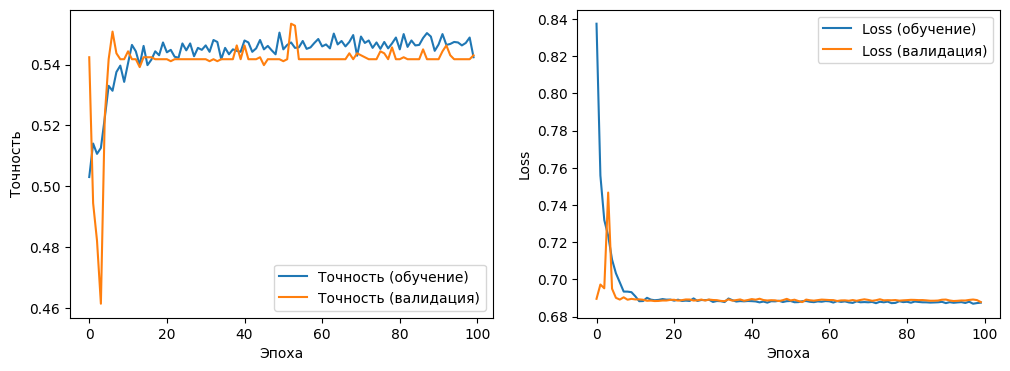

----------------------------------------------------
Тестирование
----------------------------------------------------
Точность: 53.62%


In [ ]:
model_pr_g3 = predict_game_3(match_train, hero_num)
predict_test_3(model_pr_g3, match_test, hero_num)

## ИТОГ

In [ ]:
def predict_game(match_train, hero_number=200, debug=True):
    ### ПОДГОТОВКА ВХОДНЫХ ДАННЫХ ###
    radiant_ids, dire_ids, y_train, radiant_stats, dire_stats = [], [], [], [], []
    for match in match_train:
        radiant_ids.append(list(map(int, match['radiant_heroes'])))
        dire_ids.append(list(map(int, match['dire_heroes'])))
        y_train.append(int(match['winner']))
        def extract_team_stats(team_info):
            return np.mean([
                [
                    p['kills'],
                    p['assists'],
                    p['gold_per_min'],
                    p['xp_per_min'],
                    p['hero_damage'],
                    p['tower_damage']
                ]
                for p in team_info
            ], axis=0)
        radiant_stats.append(extract_team_stats(match['radiant_players_info']))
        dire_stats.append(extract_team_stats(match['dire_players_info']))
    radiant_ids = np.array(radiant_ids)
    dire_ids = np.array(dire_ids)
    y_train = np.array(y_train)
    radiant_stats = np.array(radiant_stats)
    dire_stats = np.array(dire_stats)
    radiant_input = layers.Input(shape=(5,), name="radiant_input")
    dire_input = layers.Input(shape=(5,), name="dire_input")
    embed_dim = 64
    hero_embedding = layers.Embedding(
        input_dim=hero_number + 1,
        output_dim=embed_dim,
        name="hero_embedding"
    )

    radiant_emb = hero_embedding(radiant_input)
    dire_emb    = hero_embedding(dire_input)
    radiant_team = layers.GlobalAveragePooling1D()(radiant_emb)
    dire_team    = layers.GlobalAveragePooling1D()(dire_emb)
    diff_teams = layers.Subtract()([radiant_team, dire_team])
    combined = layers.Concatenate()([radiant_team, dire_team, diff_teams])
    reg = regularizers.l2(1e-6)

    x = layers.Dense(64, activation='relu', kernel_regularizer=reg)(combined)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.1)(x)
    x = layers.Dense(32, activation='relu', kernel_regularizer=reg)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.1)(x)

    # Выходы
    win_output = layers.Dense(1, activation='sigmoid', name="win_output")(x)
    radiant_eff_output = layers.Dense(6, name="radiant_eff")(x)
    dire_eff_output = layers.Dense(6, name="dire_eff")(x)

    model = models.Model(
        inputs=[radiant_input, dire_input],
        outputs=[win_output, radiant_eff_output, dire_eff_output]
    )

    model.compile(
        optimizer=optimizers.Adam(learning_rate=1e-4),
        loss={
            "win_output": "binary_crossentropy",
            "radiant_eff": "mse",
            "dire_eff": "mse"
        },
        loss_weights={
            "win_output": 1.0,
            "radiant_eff": 0.2,
            "dire_eff": 0.2
        },
        metrics={
            "win_output": "accuracy"
        }
    )

    early_stopping = callbacks.EarlyStopping(
        monitor='val_loss',
        patience=12,
        restore_best_weights=True
    )
    model_checkpoint = callbacks.ModelCheckpoint(
        'best_model_v5.keras',
        monitor='val_loss',
        save_best_only=True
    )
    lr_scheduler = callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5
    )

    ### ОБУЧЕНИЕ ###
    history = model.fit(
        [radiant_ids, dire_ids],
        {
            "win_output": y_train,
            "radiant_eff": radiant_stats,
            "dire_eff": dire_stats
        },
        epochs=100,
        batch_size=128,
        validation_split=0.2,
        callbacks=[early_stopping, model_checkpoint, lr_scheduler],
        verbose=1 if debug else 0
    )


    if debug:
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 2, 1)
        plt.plot(history.history['win_output_accuracy'], label='Точность (обучение)')
        plt.plot(history.history['val_win_output_accuracy'], label='Точность (валидация)')
        plt.xlabel("Эпоха")
        plt.ylabel("Точность")
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(history.history['win_output_loss'], label='Loss (обучение)')
        plt.plot(history.history['val_win_output_loss'], label='Loss (валидация)')
        plt.xlabel("Эпоха")
        plt.ylabel("Loss")
        plt.legend()

        plt.show()

    return model

In [ ]:
def predict_test(model, match_test):
    import numpy as np

    print('-'*52 + '\nТестирование\n' + '-'*52)

    radiant_ids, dire_ids = [], []
    true_labels = []

    for match in match_test:
        radiant = list(map(int, match['radiant_heroes']))
        dire = list(map(int, match['dire_heroes']))
        radiant_ids.append(radiant)
        dire_ids.append(dire)
        true_labels.append(int(match['winner']))

    radiant_ids = np.array(radiant_ids)
    dire_ids = np.array(dire_ids)
    true_labels = np.array(true_labels)

    predictions = model.predict([radiant_ids, dire_ids], verbose=0)[0]
    predicted_labels = (predictions.flatten() >= 0.5).astype(int)

    correct = (predicted_labels == true_labels).sum()
    print(f"Точность: {round((correct / len(true_labels)) * 100, 2)}%")

Epoch 1/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - dire_eff_loss: 130470800.0000 - loss: 52912052.0000 - radiant_eff_loss: 134076104.0000 - win_output_accuracy: 0.5032 - win_output_loss: 0.8999 - val_dire_eff_loss: 135544208.0000 - val_loss: 53913420.0000 - val_radiant_eff_loss: 137369408.0000 - val_win_output_accuracy: 0.5346 - val_win_output_loss: 0.6923 - learning_rate: 1.0000e-04
Epoch 2/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - dire_eff_loss: 130470488.0000 - loss: 52911880.0000 - radiant_eff_loss: 134075552.0000 - win_output_accuracy: 0.5090 - win_output_loss: 0.8855 - val_dire_eff_loss: 135545040.0000 - val_loss: 53913588.0000 - val_radiant_eff_loss: 137369424.0000 - val_win_output_accuracy: 0.5307 - val_win_output_loss: 0.6919 - learning_rate: 1.0000e-04
Epoch 3/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - dire_eff_loss: 130470200.0000 - loss: 52911744.0000 - radiant_eff_loss: 134075160.0000 - win_output_accuracy: 0.4950 - win_output_loss: 0.8904 - val_dire_eff_loss: 1355

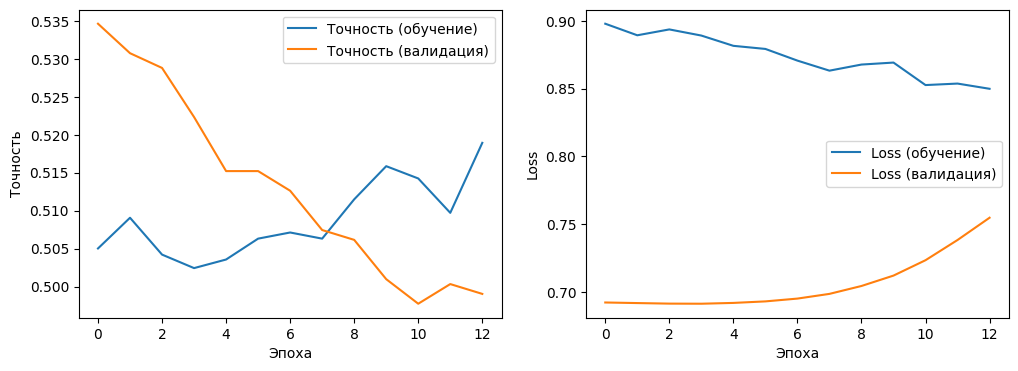

In [ ]:
model_pr_g = predict_game(match_train, hero_number=hero_num, debug=True)

In [ ]:
predict_test(model_pr_g, match_test)

----------------------------------------------------
Тестирование
----------------------------------------------------
Точность: 54.61%


55%! У нас есть перевес в 5%, что на самом деле немало.

## СИСТЕМА ОПРЕДЕЛЕНИЯ КОНТРПИКОВ

Наконец, допишем код, ради которого мы пришли: научить модель выбирать оптимальный состав под соперника.

Epoch 1/60
773/773 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.0384 - loss: 0.2418
Epoch 2/60
773/773 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.0576 - loss: 0.1371
Epoch 3/60
773/773 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.0670 - loss: 0.1365
Epoch 4/60
773/773 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.0618 - loss: 0.1359
Epoch 5/60
773/773 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.0701 - loss: 0.1350
Epoch 6/60
773/773 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.0742 - loss: 0.1340
Epoch 7/60
773/773 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.0602 - loss: 0.1336
Epoch 8/60
773/773 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.0759 - loss: 0.1327
Epoch 9/60
773/773 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.0712 - loss: 0.1321
Epoch 10/60
773/773 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.0710 - loss: 0.1316
Epoch 11/60
773/773 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.0648 - loss: 0.1304
Epoch 12/60
773/773 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step

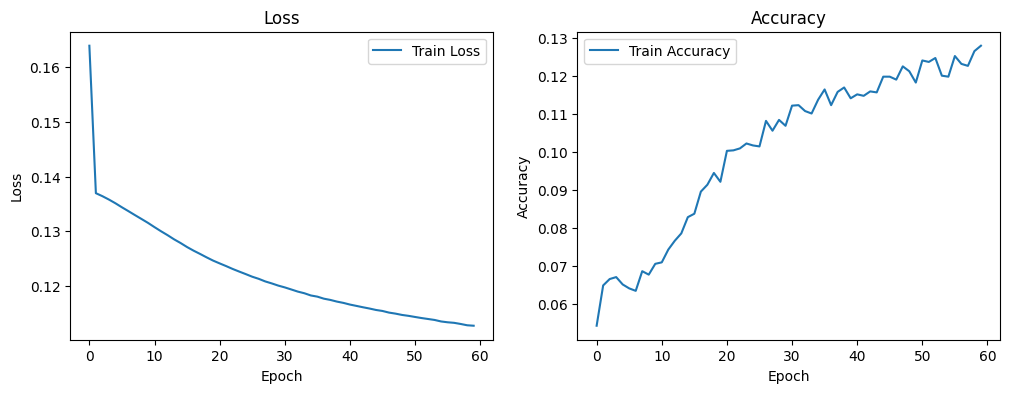

In [ ]:
def vectorize(op_team, hero_number=200):
    vector = np.zeros(hero_number)
    for h in op_team:
        vector[h - 1] = 1
    return vector

def hero_picker_train(match_train, hero_number=200, debug=True):
    X = []  # Вход: Проигравшая команда
    Y = []  # Выход: Команда, которая их победила/побеждает
    for match in match_train:
        radiant = list(map(int, match['radiant_heroes']))
        dire = list(map(int, match['dire_heroes']))
        l = radiant
        w = dire
        # Если Radiant победили, то проиграла команда Dire
        if match['winner']:
            l = dire
            w = radiant
        X.append(vectorize(l, hero_number))
        Y.append(vectorize(w, hero_number))
    X = np.array(X)
    Y = np.array(Y)

    ### МОДЕЛЬ ###
    model_config = {
        'shape': hero_number,
        'layers': [
            {'type': 'Dense', 'units': 128, 'activation': 'relu'},
            {'type': 'Dense', 'units': 64, 'activation': 'relu'},
            {'type': 'Dense', 'units': 32, 'activation': 'relu'},
            {'type': 'Dense', 'units': hero_number, 'activation': 'sigmoid'}
        ]
    }
    model = Sequential()
    model.add(layers.InputLayer(shape=(model_config['shape'],)))
    for layer_conf in model_config['layers']:
        model.add(layers.Dense(layer_conf['units'], activation=layer_conf['activation']))

    ### ОБУЧЕНИЕ ###
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    history = model.fit(X, Y, epochs=60, batch_size=10, verbose=1 if debug else 0)

    if debug:
        plt.figure(figsize=(12,4))
        plt.subplot(1, 2, 1)
        plt.plot(history.history['loss'], label='Train Loss')
        plt.title('Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.subplot(1, 2, 2)
        plt.plot(history.history['accuracy'], label='Train Accuracy')
        plt.title('Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.show()
    return model

picker_model = hero_picker_train(match_train, hero_number=hero_num, debug=True)

Процент точности небольшой, но это связано с тем, что при обучении мы требовали угадать тех самых персонажей, которые обыграли пятёрку проигравших.
При этом можно видеть, что обучение на графике происходило.

In [34]:
def beautify(name):  # Обработка имён героев
    return name.replace("-", " ").title()

def hero_picker(model, lineup, extend=False, hero_number=200):
    print("Способ задания команды:\n1 - Сгенерировать случайную команду\n2 - Ввести команду вручную\n")
    choice = input("Выбор (1 или 2): ").strip()
    if choice == "1":
        opponent_lineup = rnd.sample(list(Heroes_id.values()), 5)
    elif choice == "2":
        user_input = input("Введите 5 героев (через запятые или пробелы): ").strip()
        if ',' in user_input:
            parts = [p.strip() for p in user_input.split(',')]
        else:
            parts = user_input.split()

        opponent_lineup = []
        for item in parts:
            try:
                hero_id = int(item)
                if hero_id < 1 or hero_id > hero_number:
                    print(f"Ошибка: id героя {hero_id} должен быть от 1 до {hero_number}.")
                    continue
                opponent_lineup.append(hero_id)
            except ValueError:
                found = False
                for name, hid in Heroes_id.items():
                    if name.lower() == item.lower():
                        if hid < 1 or hid > hero_number:
                            print(f"Ошибка: id героя {hid} должен быть от 1 до {hero_number}.")
                            found = True
                            break
                        opponent_lineup.append(hid)
                        found = True
                        break
                if not found:
                    print(f"Герой '{item}' не найден.")
    else:
        print("Ошибка, генерирую случайную команду.")
        opponent_lineup = rnd.sample(list(Heroes_id.values()), 5)

    X = vectorize(opponent_lineup, hero_number).reshape(1, -1)
    preds = model.predict(X, verbose=0)[0]
    preds = [round(p, 2) for p in preds]
    recommended_indices = np.argsort(preds)[-5:][::-1]
    recommended_heroes = [int(ind) + 1 for ind in recommended_indices]

    print("\nКоманда соперника:")
    for h in opponent_lineup:
        print(f"* {beautify(Heroes[h])}")
    print("\nРекомендуемые герои:")
    if extend:
        for idx in recommended_indices:
            per = round(preds[idx] * 100, 2)
            print(f"* {beautify(Heroes[int(idx) + 1])} - {per}%")
    else:
        for h in recommended_heroes:
            print(f"* {beautify(Heroes[h])}")
    return recommended_heroes

Наконец, мы дописали подбор героев.

Можно выбрать генератор команды соперника (протестировать работу), или ввести вручную

Можно вводить id или в виде строчки

Можно ввести от до 5 персонажей, ведь во время драфта ещё не все герои матча могут быть известны, а только часть.

Параметр extend позволяет вывести точность выбора в процентах.

In [41]:
opponent_heroes = rnd.sample(list(Heroes_id.values()), 5)
recommended_heroes = hero_picker(picker_model, opponent_heroes, extend=True, hero_number=hero_num)

Способ задания команды:
1 - Сгенерировать случайную команду
2 - Ввести команду вручную

Выбор (1 или 2): 2
Введите 5 героев (через запятые или пробелы): 1 5 10 20 30

Команда соперника:
* Anti Mage
* Crystal Maiden
* Morphling
* Vengeful Spirit
* Witch Doctor

Рекомендуемые герои:
* Ogre Magi - 31.0%
* Drow Ranger - 28.0%
* Riki - 27.0%
* Huskar - 25.0%
* Spectre - 23.0%


# Заключение

Мы обучили нашу модель на сформированном датасете и начились предсказывать с ветроятностью больше 50% исход матча, а так же написали подбор оптимальных контрпиков.